# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import glob
import re
import datetime
from datetime import datetime
import seaborn as sns

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'D:\!User\Downloads\DS\HW05\capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    csv_file_path = glob.glob(path_to_csv_files)
    df = [pd.read_csv(file) for file in csv_file_path]
    with open(site_freq_path, 'rb') as site_freq_file:
        dictionary = pickle.load(site_freq_file)
    user_ids = [int(re.search('([1-9][0-9]*).csv$', path).group(1)) for path in csv_file_path]
    list = []
    for index, series in enumerate(df):
        session =  series['site']
        for i, site in enumerate(session):
            session[i] = dictionary[site][0]
        line = len(session)
        k = session_length//window_size
        rows = line //(k*window_size) if line % (k*window_size) == 0 else line // (k*window_size) + 1
        session = np.pad(session, (0, int(np.ceil((rows*k*window_size))- len(session))), mode='constant').\
            reshape(rows, ((k*window_size)))
        sessions = pd.DataFrame(session)
                
        time = series['timestamp'].astype('datetime64') 
        sec = time[1:].append(time[-1:])
        time_diff = (sec.to_numpy()-time.to_numpy()).astype('timedelta64[s]').astype('int64')
        time_diff = np.pad(time_diff, (0, int(np.ceil((rows*k*window_size))- line)), mode='constant').\
            reshape(rows, ((k*window_size)))
        time_diffs = pd.DataFrame(time_diff[:, :-1])
        
        session_timespan = time_diff.sum(axis=1)
        session_timespan = pd.DataFrame(session_timespan)
        
        unique_sites = [len(np.unique(i[i!=0])) for i in session] 
              
        #day_of_week = [min(time[i].weekday()  for i in session]
        #start_hour = [min(time[i]).hour for i in sessions.loc[: line]]
        
        start_hour = []
        day_of_week = []
        x=0
        while x<line: 
            start_hour.append((time[x]).hour)
            day_of_week.append((time[x]).weekday())
            x+= session_length
          
        unique_sites = pd.DataFrame(unique_sites)
        start_hour = pd.DataFrame(start_hour)
        day_of_week = pd.DataFrame(day_of_week)
         
        full = pd.concat((sessions, time_diffs, session_timespan, unique_sites, start_hour, day_of_week),axis=1)\
        .assign(target = user_ids[index])
        list.append(full)
    features = pd.concat(list, ignore_index = True)
    features.columns = feature_names
    return features
        


**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users', "*.csv"), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,9,5,8,10,287,1184,6278,186,2,1,2,3,55,11538,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,10800,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users', "*.csv"), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 30.7 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,576,134,3,134,134,3,134,203,134,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,425,193,674,255,134,31,393,4346,219,55,1,0,163,105,0,1,3,3,8,285,10,8,4,31
2,55,3,55,55,5,293,425,339,901,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,474,3508,474,55,55,55,55,973,202,124,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,343,55,5,3982,259,212,3986,2312,690,2312,1,0,1,1,1,0,1,1,0,7,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users', "*.csv"), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 4min 32s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_names = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [10]:
new_features_10users = train_data_10users[new_features_names]
new_features_150users = train_data_150users[new_features_names]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [12]:
new_features_10users['session_timespan'].median()

43.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [13]:
new_features_10users['day_of_week'].median()

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [14]:
new_features_10users['start_hour'].median()

14.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [15]:
new_features_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [16]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [17]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

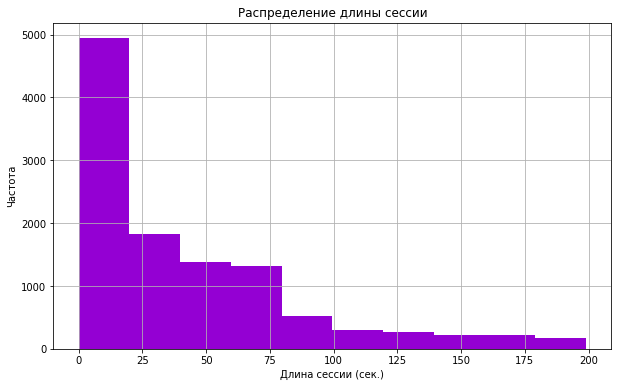

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(train_data_10users['session_timespan'][train_data_10users.session_timespan < 200],color='darkviolet')
plt.title('Распределение длины сессии')
plt.xlabel('Длина сессии (сек.)')
plt.ylabel('Частота')
plt.grid()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

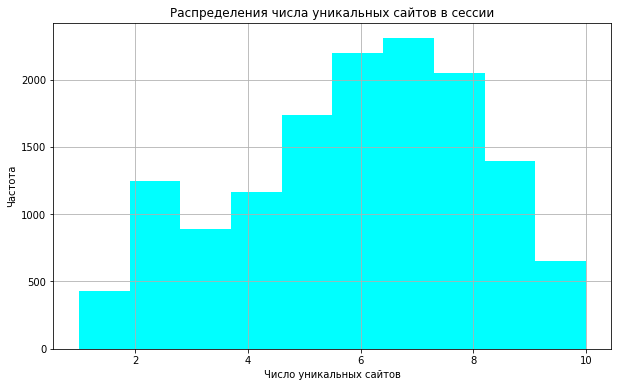

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(train_data_10users['#unique_sites'],color='aqua')
plt.title('Pаспределения числа уникальных сайтов в сессии')
plt.xlabel('Число уникальных сайтов')
plt.ylabel('Частота')
plt.grid()


**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

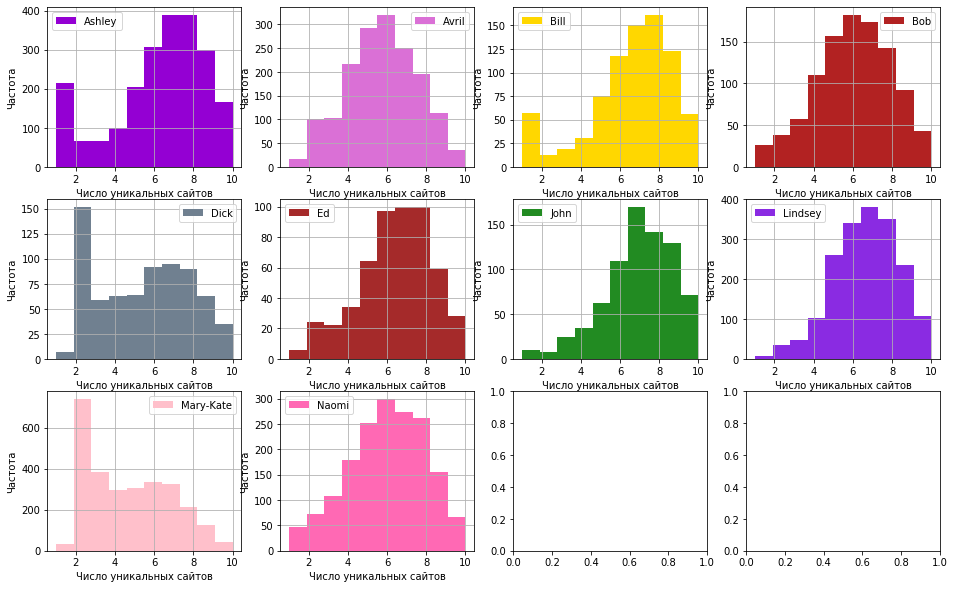

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(train_data_10users['target'])): 
    sub_df['#unique_sites'].plot(kind='hist', ax=axes[idx//4, idx%4], color=color_dic[user], legend=True, grid = 20)
    axes[idx//4, idx%4].set_xlabel(u'Число уникальных сайтов')
    axes[idx//4, idx%4].set_ylabel(u'Частота')
    axes[idx//4, idx%4].legend([user])
    

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

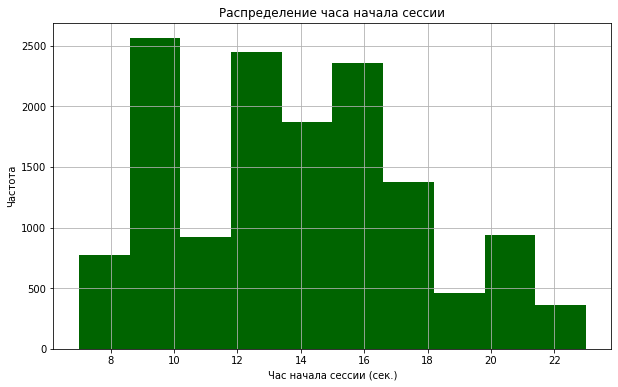

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(train_data_10users['start_hour'],color='darkgreen')
plt.title('Распределение часа начала сессии')
plt.xlabel('Час начала сессии (сек.)')
plt.ylabel('Частота')
plt.grid()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

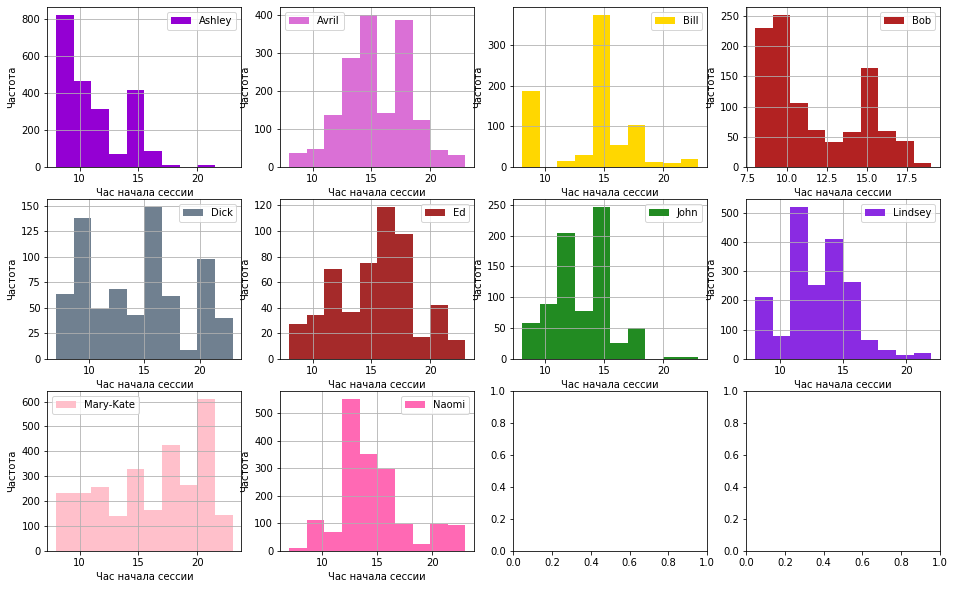

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(train_data_10users['target'])): 
    sub_df['start_hour'].plot(kind='hist', ax=axes[idx//4, idx%4], color=color_dic[user], legend=True, grid = 20)
    axes[idx//4, idx%4].set_xlabel(u'Час начала сессии')
    axes[idx//4, idx%4].set_ylabel(u'Частота')
    axes[idx//4, idx%4].legend([user])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

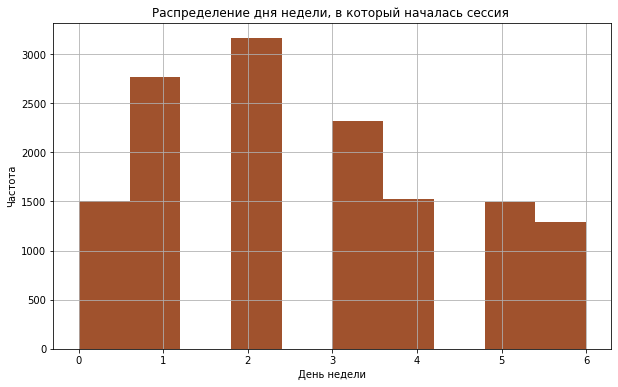

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(train_data_10users['day_of_week'],color='sienna')
plt.title('Распределение дня недели, в который началась сессия ')
plt.xlabel('День недели')
plt.ylabel('Частота')
plt.grid()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

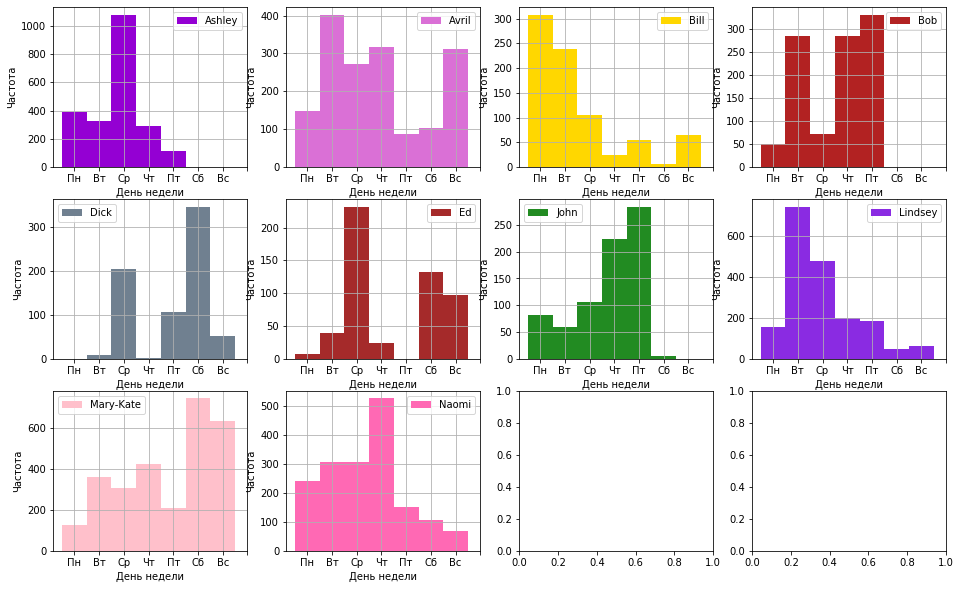

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby(train_data_10users['target'])): 
    sub_df['day_of_week'].plot(kind='hist', ax=axes[idx//4, idx%4], color=color_dic[user], legend=True, grid = 20,\
                               bins=np.arange(-0.5,7,1), xticks=range(8))
    axes[idx//4, idx%4].set_xlabel(u'День недели')
    axes[idx//4, idx%4].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
    axes[idx//4, idx%4].set_ylabel(u'Частота')
    axes[idx//4, idx%4].legend([user])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1. Ashley выходит в сеть в будни, среда самый активный день; в утренние часы и после обеда(15-00); есть "любимый сайт" и немного посещает другие.
2. Avrill бывает в интернете каждый день, активно во вторник, пт-сб менее активно; в обеденное и вечернее время, бывает на разных сайтах. 
3. Bill активно юзает в понедельник и практически не юзает в субботу; активно днем и немногог меньше утром, быввает на разных сайтах и есть "любимые".
4. Bob не бывает на выходных в интернете, активные дни - вт, чт, пт; вечером не захожит, большая активность утром и немного днем, посещает разные сайты.
5. Dick не заходит в интренет в пн и чт, активный на выходных и в среду; бывает на протяжении дня в разное время; есть "любимые" сайты.
6. Ed самый активный день среда и выходные, не бывает в сети в пятницу; заходит в течение дня, вечером активнее; посещает разные сайты.
7. John активный в сети на буднях, особенно чт-пт; в первой половине дня; бывает на разных сайтах.
8. Lindsey пользуется интернетом каждый день, на выходных актвне пик - вт и ср; активные часы обеденное время и немного утром, юзает разные сайты.
9. Mary-Kate пользуется интернетом каждый день, на выходных активнее; в течение дня заходит, большая активность вечером; есть "любимые" сайты.
10. Naomi заходит на сайты каждый день, активный день чт, на выходных реже; активное время - середина дня; юзает разные сайты.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [25]:
with open(os.path.join('site_freq_10users.pkl'), 'rb') as site_freq_10users:
    site_freq_10users = pickle.load(site_freq_10users)


**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [26]:
top = pd.DataFrame.from_dict(site_freq_10users, orient= 'index')
top[0:10]

,0,1
s.youtube.com,1,8300
www.google.fr,2,7813
www.google.com,3,5441
mail.google.com,4,4158
www.facebook.com,5,4141
apis.google.com,6,3758
r3---sn-gxo5uxg-jqbe.googlevideo.com,7,3244
r1---sn-gxo5uxg-jqbe.googlevideo.com,8,3094
plus.google.com,9,2630
accounts.google.com,10,2089


In [27]:
top10_sites = top[:10][0].index
top10_sites

Index(['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com',
       'www.facebook.com', 'apis.google.com',
       'r3---sn-gxo5uxg-jqbe.googlevideo.com',
       'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com',
       'accounts.google.com'],
      dtype='object')

In [28]:
top10_freqs = top[:10][1]
top10_freqs


s.youtube.com                           8300
www.google.fr                           7813
www.google.com                          5441
mail.google.com                         4158
www.facebook.com                        4141
apis.google.com                         3758
r3---sn-gxo5uxg-jqbe.googlevideo.com    3244
r1---sn-gxo5uxg-jqbe.googlevideo.com    3094
plus.google.com                         2630
accounts.google.com                     2089
Name: 1, dtype: int64

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

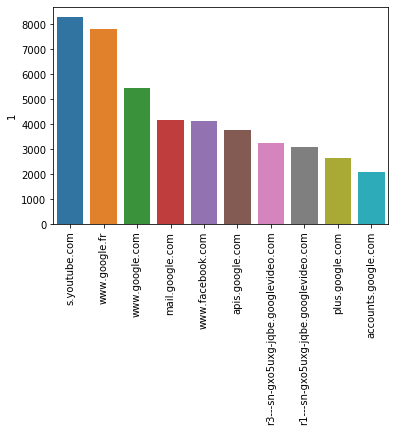

In [29]:
g = sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [30]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    with open(features, 'rb') as features:
        features = pickle.load(features)
    new_features= pd.DataFrame(features)
    df_new_data = new_features.copy()
    df_new_data['log_session_timespan'] = df_new_data['session_timespan'].apply(lambda x: np.log(x + 1))
    df_new_data['mean_session_timespan'] = df_new_data['session_timespan']/df_new_data['#unique_sites']
    df_new_data['weekdays'] = df_new_data['day_of_week'].apply(lambda x: int(x <= 5))
    df_new_data['big_session_timespan'] = df_new_data['session_timespan'].apply(lambda x: int(x > 10000))
    df_new_data['small_unique_sites'] = df_new_data['#unique_sites'].apply(lambda x: int(x <=3))
    df_new_data['morning_session'] = df_new_data['start_hour'].apply(lambda x: int(6 <= x and x < 12))
    df_new_data['afternoon_session'] = df_new_data['start_hour'].apply(lambda x: int(12 <= x and x < 18))
    df_new_data['evening_session'] = df_new_data['start_hour'].apply(lambda x: int(18 <= x and x < 24))
    df_new_data['night_session'] = df_new_data['start_hour'].apply(lambda x: int(0 <= x and x < 6))
    
    #feature = ['log_session_timespan' + 'mean_session_timespan' + 'weekdays']
    return df_new_data
feature = feature_engineering(os.path.join(PATH_TO_DATA, '3users', "*.csv"), 
                  features=os.path.join(PATH_TO_DATA, 
                                              'new_features_10users.pkl'), session_length=10)
feature.head()

,session_timespan,#unique_sites,start_hour,day_of_week,log_session_timespan,mean_session_timespan,weekdays,big_session_timespan,small_unique_sites,morning_session,afternoon_session,evening_session,night_session
0,33,5,8,4,3.526361,6.600000,1,0,0,1,0,0,0
1,285,10,8,4,5.655992,28.500000,1,0,0,1,0,0,0
2,258,7,8,4,5.556828,36.857143,1,0,0,1,0,0,0
3,30,6,8,4,3.433987,5.000000,1,0,0,1,0,0,0
4,7,9,8,4,2.079442,0.777778,1,0,0,1,0,0,0


In [31]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '3users', "*.csv"), 
                  features=os.path.join(PATH_TO_DATA, 
                                              'new_features_10users.pkl'), session_length=10)
new_features_10users.head()

,session_timespan,#unique_sites,start_hour,day_of_week,log_session_timespan,mean_session_timespan,weekdays,big_session_timespan,small_unique_sites,morning_session,afternoon_session,evening_session,night_session
0,33,5,8,4,3.526361,6.600000,1,0,0,1,0,0,0
1,285,10,8,4,5.655992,28.500000,1,0,0,1,0,0,0
2,258,7,8,4,5.556828,36.857143,1,0,0,1,0,0,0
3,30,6,8,4,3.433987,5.000000,1,0,0,1,0,0,0
4,7,9,8,4,2.079442,0.777778,1,0,0,1,0,0,0


In [32]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '3users', "*.csv"), 
                  features=os.path.join(PATH_TO_DATA, 
                                              'new_features_150users.pkl'), session_length=10)
new_features_150users.head()

,session_timespan,#unique_sites,start_hour,day_of_week,log_session_timespan,mean_session_timespan,weekdays,big_session_timespan,small_unique_sites,morning_session,afternoon_session,evening_session,night_session
0,57,5,8,4,4.060443,11.40,1,0,0,1,0,0,0
1,1620,8,8,4,7.390799,202.50,1,0,0,1,0,0,0
2,2027,5,8,4,7.614805,405.40,1,0,0,1,0,0,0
3,2009,4,9,4,7.605890,502.25,1,0,0,1,0,0,0
4,10,5,9,4,2.397895,2.00,1,0,0,1,0,0,0


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

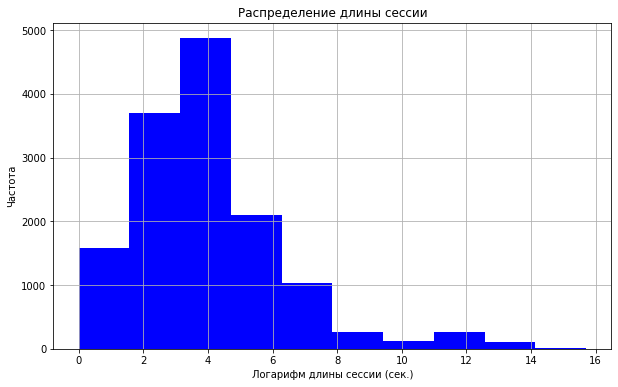

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(new_features_10users['log_session_timespan'], color='blue')
plt.title('Распределение длины сессии')
plt.xlabel('Логарифм длины сессии (сек.)')
plt.ylabel('Частота')
plt.grid()

In [34]:
features_with_target10 = pd.concat([new_features_10users, train_data_10users['target']], axis=1)
features_with_target150 = pd.concat([new_features_150users, train_data_150users['target']], axis=1)


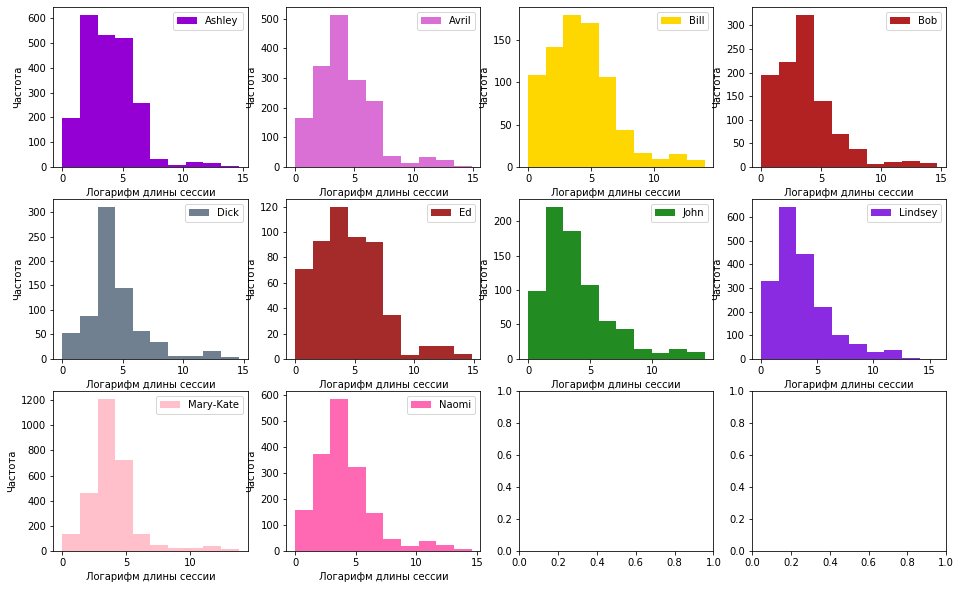

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#посмотрим для каждого пользователя отдельно 
for idx, (user, sub_df) in  enumerate(features_with_target10.groupby(features_with_target10['target'])): 
    sub_df['log_session_timespan'].plot(kind='hist', ax=axes[idx//4, idx%4], color=color_dic[user], legend=True, bins=10)
    axes[idx//4, idx%4].set_xlabel('Логарифм длины сессии')
    axes[idx//4, idx%4].set_ylabel('Частота')
    axes[idx//4, idx%4].legend([user])



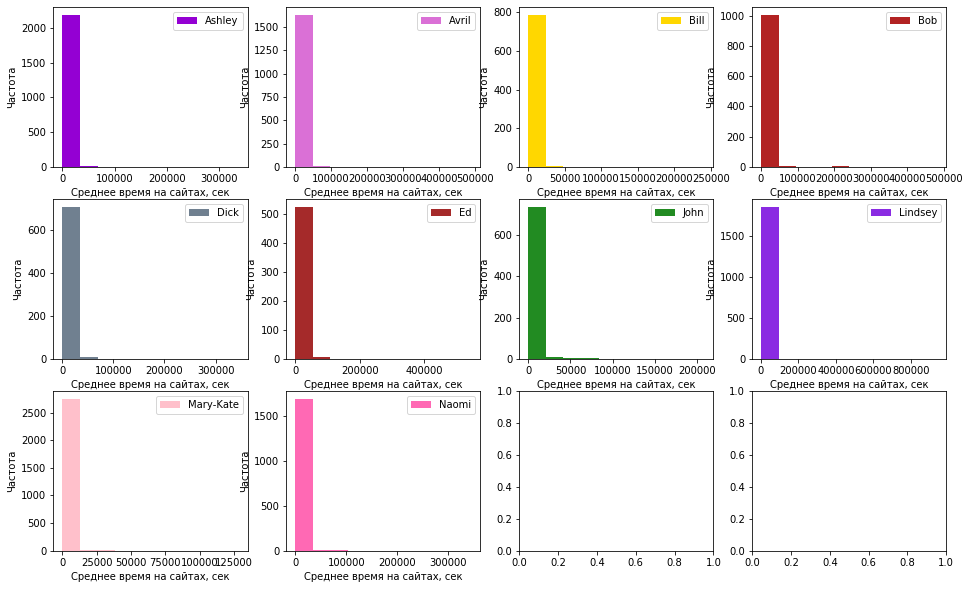

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#посмотрим для каждого пользователя отдельно 
for idx, (user, sub_df) in  enumerate(features_with_target10.groupby(features_with_target10['target'])): 
    sub_df['mean_session_timespan'].plot(kind='hist', ax=axes[idx//4, idx%4], color=color_dic[user], legend=True, bins=10)
    axes[idx//4, idx%4].set_xlabel('Среднее время на сайтах, сек')
    axes[idx//4, idx%4].set_ylabel('Частота')
    axes[idx//4, idx%4].legend([user])


Из ваше графиков мы видим активных пользователей: Mary_Kate, Ashley, Avril, Naoni, и тех, кто пребывает на сайтах недолго: Dick, Ed, John. 

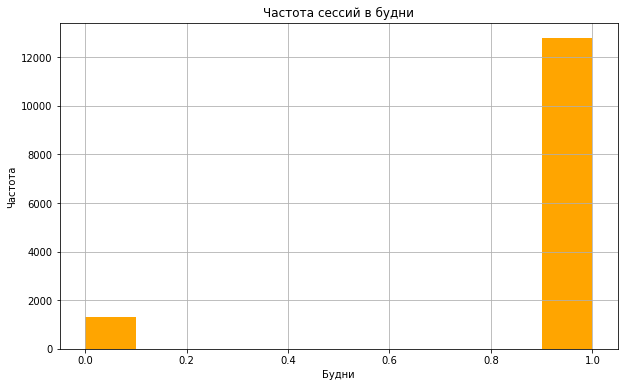

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(new_features_10users['weekdays'], color='orange')
plt.title('Частота сессий в будни')
plt.xlabel('Будни')
plt.ylabel('Частота')
plt.grid()

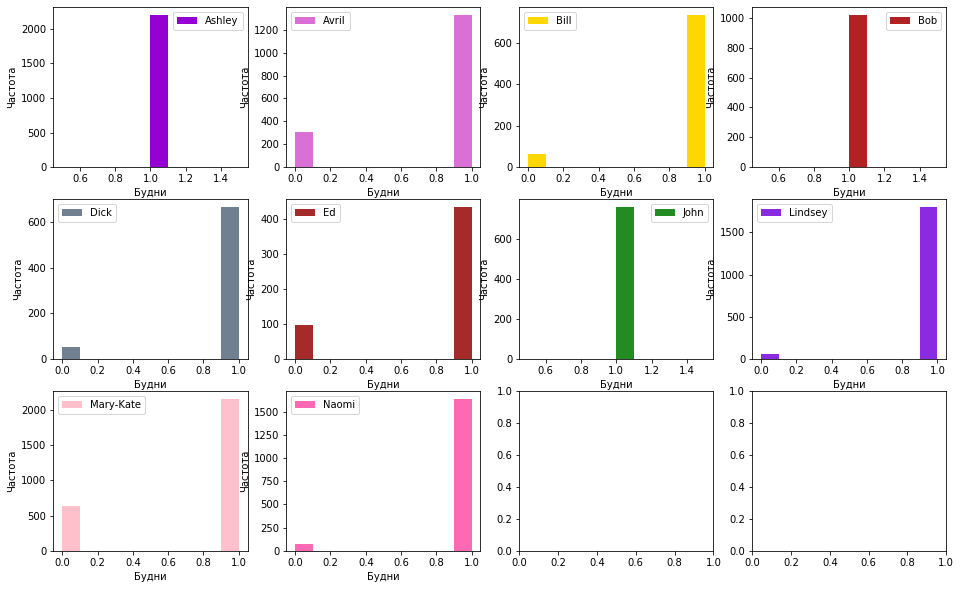

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#посмотрим для каждого пользователя отдельно 
for idx, (user, sub_df) in  enumerate(features_with_target10.groupby(features_with_target10['target'])): 
    sub_df['weekdays'].plot(kind='hist', ax=axes[idx//4, idx%4], color=color_dic[user], legend=True, bins=10)
    axes[idx//4, idx%4].set_xlabel('Будни')
    axes[idx//4, idx%4].set_ylabel('Частота')
    axes[idx//4, idx%4].legend([user])


Из графиков мы видим, что Bob, Ashley и Jonh не заходят на сайты по выходным. Мы видем кто активнее юзает на выходных, а кто в будни. 

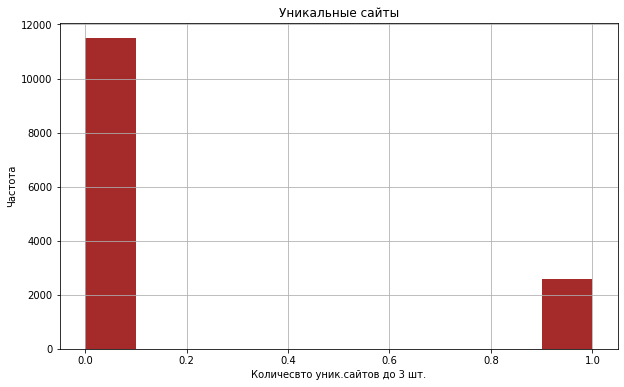

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(new_features_10users['small_unique_sites'], color='brown')
plt.title('Уникальные сайты')
plt.xlabel('Количесвто уник.сайтов до 3 шт.')
plt.ylabel('Частота')
plt.grid()

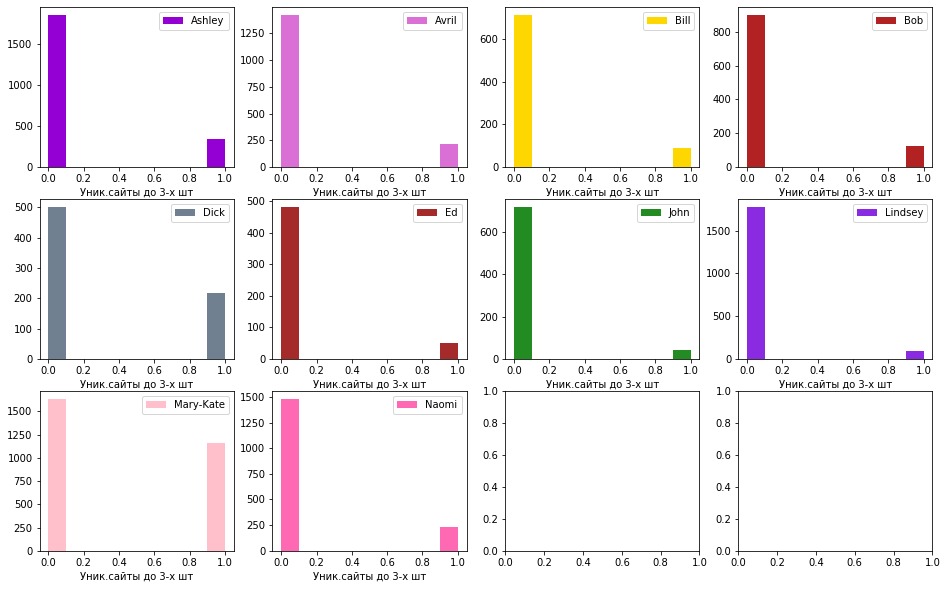

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#посмотрим для каждого пользователя отдельно 
for idx, (user, sub_df) in  enumerate(features_with_target10.groupby(features_with_target10['target'])): 
    sub_df['small_unique_sites'].plot(kind='hist', ax=axes[idx//4, idx%4], color=color_dic[user], legend=True, bins=10)
    axes[idx//4, idx%4].set_xlabel('Уник.сайты до 3-х шт')
    axes[idx//4, idx%4].set_ylabel('')
    axes[idx//4, idx%4].legend([user])


Можем выделить несколько пользователей, которые часто пользуются одними и теми же сайтами.

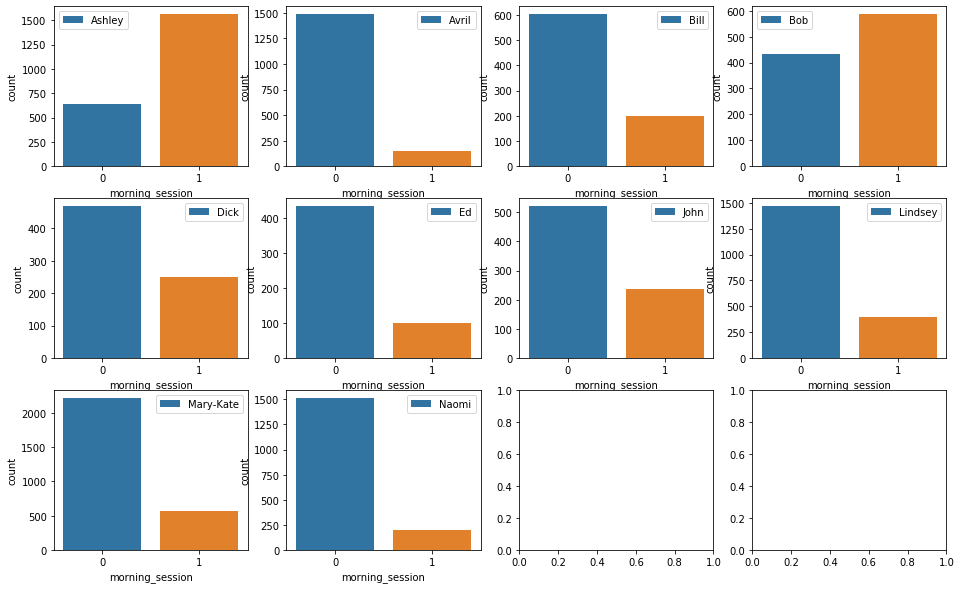

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#посмотрим для каждого пользователя отдельно 
for idx, (user, sub_df) in  enumerate(features_with_target10.groupby(features_with_target10['target'])): 
    sns.countplot(sub_df['morning_session'], ax=axes[idx//4, idx % 4], label=user)
    axes[idx//4, idx % 4].legend()
    
    

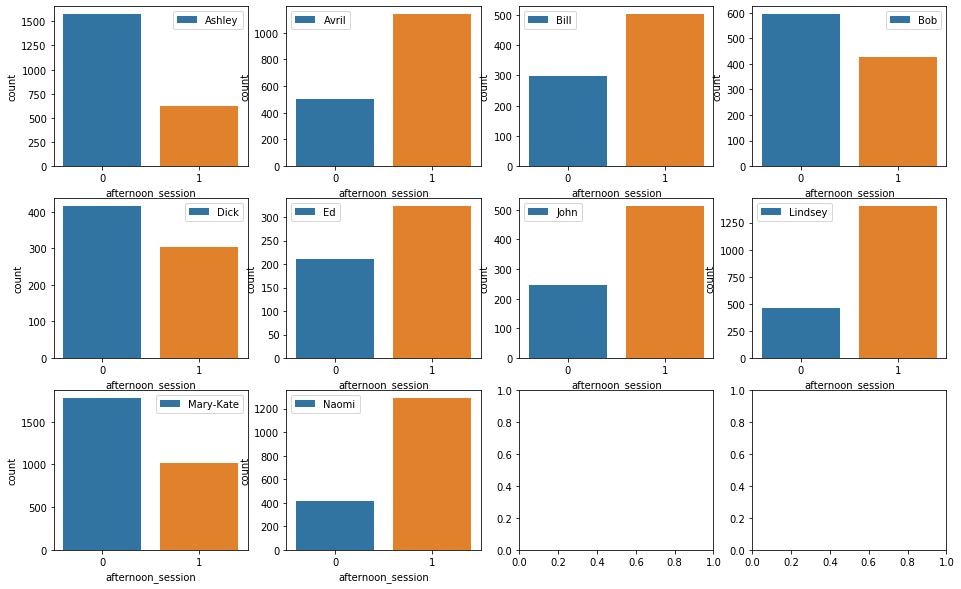

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#посмотрим для каждого пользователя отдельно 
for idx, (user, sub_df) in  enumerate(features_with_target10.groupby(features_with_target10['target'])): 
    sns.countplot(sub_df['afternoon_session'], ax=axes[idx//4, idx % 4], label=user)
    axes[idx//4, idx % 4].legend()

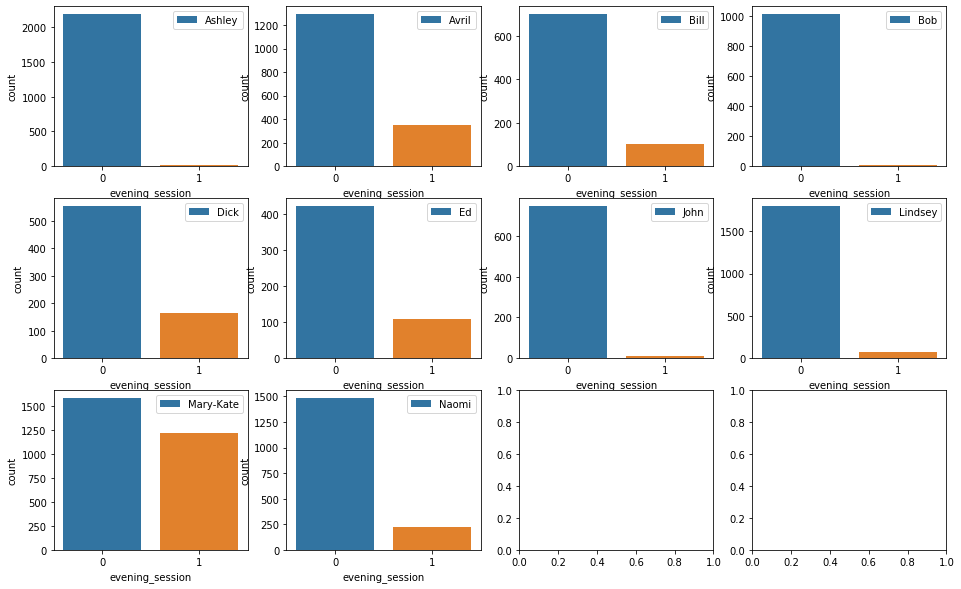

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

#посмотрим для каждого пользователя отдельно 
for idx, (user, sub_df) in  enumerate(features_with_target10.groupby(features_with_target10['target'])): 
    sns.countplot(sub_df['evening_session'], ax=axes[idx//4, idx % 4], label=user)
    axes[idx//4, idx % 4].legend()

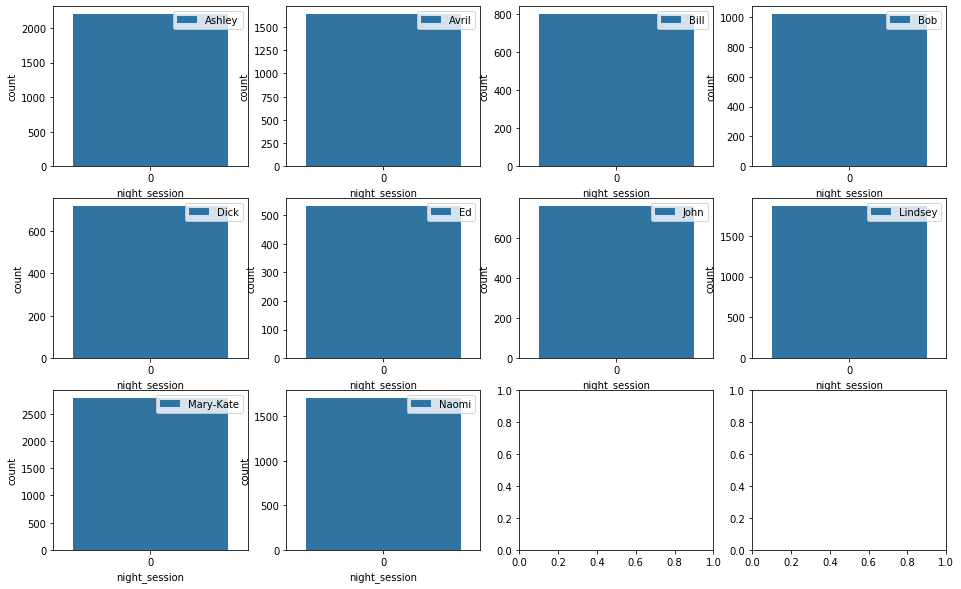

In [49]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
 
#посмотрим для каждого пользователя отдельно 
for idx, (user, sub_df) in  enumerate(features_with_target10.groupby(features_with_target10['target'])): 
    sns.countplot(sub_df['night_session'], ax=axes[idx//4, idx % 4], label=user)
    axes[idx//4, idx % 4].legend()

Мы видим, какие пользователи в какое время суток посещают сайты, признак по ночным сессиям не информативен.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [50]:
selected_features_10users = features_with_target10.drop( columns= 'night_session')
selected_features_150users = features_with_target150.drop( columns= 'night_session')


In [51]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

На следующей неделе мы наконец приступим к обучению моделей классификации. 